In [1]:
#######################################
# 05_feedback_mechanismv2.py
#######################################

import os
import pickle
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import cdist

import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

#######################################
# PART 1: Fit PCA (4096->50) & KMeans(k=6) on old (base) dataset
#######################################

def build_base_pca_kmeans(fc1, n_components=50, k=6):
    """
    fc1: shape (N, 4096), base data's features
    Return: pca (4096->50) and kmeans(6) in 50D
    """
    pca = PCA(n_components=n_components, whiten=True, svd_solver='full')
    X_50 = pca.fit_transform(fc1)  # => (N,50)

    kmeans_50d = KMeans(n_clusters=k, random_state=42, n_init=500)
    kmeans_50d.fit(X_50)

    print(f"[build_base] PCA => shape {X_50.shape}, kmeans inertia => {kmeans_50d.inertia_:.2f}")
    return pca, kmeans_50d




2025-01-29 19:13:45.531279: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-29 19:13:45.540531: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738167225.551071   28417 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738167225.554229   28417 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-29 19:13:45.566107: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
#######################################
# PART 2: System Class
#######################################

class NoveltyDetectionSystem:
    def __init__(self, pca, kmeans_50d):
        """
        pca: a PCA object converting 4096->50
        kmeans_50d: a KMeans model in 50D, e.g. 6 clusters
        """
        self.pca = pca
        self.kmeans = kmeans_50d
        self.n_clusters = kmeans_50d.n_clusters
        print(f"[INFO] PCA expects {pca.n_features_in_} features -> {pca.n_components_} dims.")
        print(f"[INFO] KMeans n_clusters={self.n_clusters} in {pca.n_components_}D space.")

    def layer_extractor(self, model=None, layer='fc1'):
        """
        Returns a Keras sub-model extracting the 'fc1' outputs from VGG16.
        """
        if model is None:
            model = keras.applications.VGG16(include_top=True, weights='imagenet')
        # confirm layer
        assert layer in [x.name for x in model.layers], f"layer {layer} not found"
        new_model = keras.Model(inputs=model.input, outputs=model.get_layer(layer).output)
        return new_model

    def load_images(self, paths):
        """
        Load each image (224x224), stack => (batch,224,224,3), then preprocess
        for VGG16
        """
        imgs = []
        for file in paths:
            pil_img = image.load_img(file, target_size=(224,224))
            arr = image.img_to_array(pil_img)
            imgs.append(arr)
        imgs = np.array(imgs)
        imgs = preprocess_input(imgs)
        return imgs

    def extract_fc1_batch(self, image_paths):
        """
        For a list of image paths, extract fc1 => shape (B,4096).
        """
        fc1_extractor = self.layer_extractor(layer='fc1')
        arr = self.load_images(image_paths)  # => (B,224,224,3)
        feats_4096 = fc1_extractor.predict(arr)  # => (B,4096)
        return feats_4096

    def cluster_new_batch_2(self, new_feats_4096):
        from sklearn.cluster import KMeans
        from scipy.spatial.distance import cdist

        new_50 = self.pca.transform(new_feats_4096)
        kmeans_2 = KMeans(n_clusters=2, random_state=42)
        kmeans_2.fit(new_50)

        new_centers_50 = kmeans_2.cluster_centers_
        print("[cluster_new_batch_2] 2 new cluster centers (2,50):")
        print(new_centers_50)

        # Distances => shape(2,6)
        old_centers_50 = self.kmeans.cluster_centers_  # shape => (6,50)
        dists = cdist(new_centers_50, old_centers_50, metric='euclidean')

        # We specifically look at distance to old center #0 (which we say is "Crazing")
        # whichever new cluster i has the smaller dists[i,0] => "Crazing"
        d_crazing = dists[:, 0]  # shape => (2,)
        i_best = np.argmin(d_crazing)  # either 0 or 1
        cluster_labels = ["new class","new class"]
        cluster_labels[i_best] = "Crazing"

        for i in range(2):
            print(f"New cluster {i}: dist to old center#0 => {d_crazing[i]:.2f} => {cluster_labels[i]}")



    def visualize_new2_tsne(self, new_feats_4096):
        """
        OPTIONAL: Just show the 2 new cluster centers in t-SNE (2D).
        """
        from sklearn.cluster import KMeans
        from sklearn.manifold import TSNE

        new_50 = self.pca.transform(new_feats_4096)
        km2 = KMeans(n_clusters=2, random_state=42)
        km2.fit(new_50)
        c2 = km2.cluster_centers_  # (2,50)

        # perplexity must be <2, let's do 1.0
        tsne = TSNE(n_components=2, random_state=0, perplexity=1.0)
        reduced = tsne.fit_transform(c2)  # => (2,2)

        plt.figure(dpi=120)
        plt.scatter(reduced[:,0], reduced[:,1], c=[0,1], s=200, cmap='viridis')
        for i in range(2):
            plt.text(reduced[i,0]+0.2, reduced[i,1], f"C{i}")
        plt.title("2 cluster centers in t-SNE")
        plt.show()





[build_base] PCA => shape (1500, 50), kmeans inertia => 68142.90
[INFO] PCA expects 4096 features -> 50 dims.
[INFO] KMeans n_clusters=6 in 50D space.
Found 40 images in new batch.


I0000 00:00:1738167228.584737   28417 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5760 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1738167230.346255   29704 service.cc:148] XLA service 0x72f148003030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738167230.346277   29704 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-01-29 19:13:50.352022: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738167230.382949   29704 cuda_dnn.cc:529] Loaded cuDNN version 90700


1/2 ━━━━━━━━━━━━━━━━━━━━ 12s 13s/step

I0000 00:00:1738167242.702682   29704 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step
[cluster_new_batch_2] 2 new cluster centers (2,50):
[[ 0.77102816  0.38407224 -0.93912524 -0.3709291  -0.00904906 -0.08808659
  -0.10220179 -0.14174001  0.30669758 -0.24474496 -0.05435992  0.18656571
   0.26308173 -0.8049092  -0.12013239 -0.29656115 -0.07668918 -0.14975327
   0.14220533  0.44010943  0.6319494  -0.09193735  0.1402443   0.50849694
  -0.0566498   0.03249258 -0.11846977  0.13665608  0.5293927  -0.39049968
   0.14546657  0.7137377  -0.37221694 -0.4619542   0.07221942 -0.11184585
  -0.40793923 -0.21846694 -0.31279722 -0.31888238  0.35420743  0.01756386
   0.10233894  0.7129724  -0.0503329   0.29069722 -0.08698771 -0.01239222
  -0.55312324 -0.23346576]
 [-0.5009197   0.5134536   0.43389004  0.17010371 -0.33119398 -0.67375195
   1.3109009   1.2114985  -0.45758936  0.9739395  -0.17460357 -1.1468709
  -0.9343192  -2.285377   -0.94846267  0.13613358 -0.00602925 -0.2378152
  -1.6286389   1.8873934   2.3895774   0.649629   -0.68550026  0.4406605

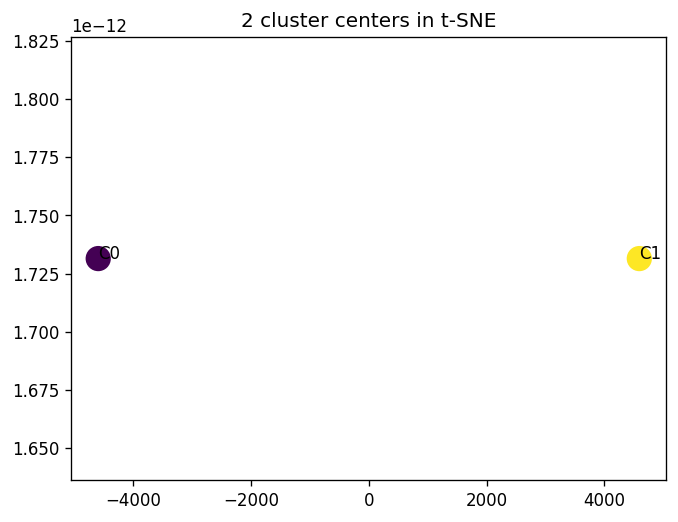

In [3]:
#######################################
# MAIN USAGE
#######################################


# (1) Load base data (fc1 => shape(N,4096))
from pathlib import Path
import pickle

fc1_path = Path('..','data','features','VGG16_fc1_features_std.pickle')
with open(fc1_path, 'rb') as f:
    base_data = pickle.load(f)
fc1 = base_data['features']  # (N,4096)
# (Optionally) labels, etc.

# (2) Build PCA(4096->50) + KMeans(6) on the old data
pca, kmeans_50d = build_base_pca_kmeans(fc1, n_components=50, k=6)

# (3) Construct system
system = NoveltyDetectionSystem(pca, kmeans_50d)

# (4) Load a new batch of images (40)
batch_dir = Path("NEU_mixed_batch_40")
batch_images = sorted(batch_dir.glob("*.bmp"))
if not batch_images:
    print(f"[WARNING] No images in {batch_dir}!")
else:
    print(f"Found {len(batch_images)} images in new batch.")

    # Extract their fc1
    new_feats_4096 = system.extract_fc1_batch(batch_images)

    # (5) Find 2 new cluster centers from the new batch (in 50D),
    #     compare to old 6 centers
    system.cluster_new_batch_2(new_feats_4096)

    # (Optional) visualize in t-SNE 2D
    system.visualize_new2_tsne(new_feats_4096)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

def plot_newbatch_tsne(new_data_50, cluster_labels_2):
    """
    new_data_50: shape (40,50) -> the new batch (already PCA-transformed).
    cluster_labels_2: shape (40,) -> 0 or 1 from your 2-cluster approach.
       (0 => cluster #0, 1 => cluster #1)
    We'll label cluster #0 => 'Crazing', cluster #1 => 'new class'
    """

    # Step A: t-SNE with a safe perplexity (< 40). e.g. perplexity=10
    tsne = TSNE(n_components=2, random_state=123, perplexity=10)
    x_2d = tsne.fit_transform(new_data_50)  # shape => (40,2)

    # Step B: Build a DataFrame for plotting
    df = pd.DataFrame({
        'x_tsne': x_2d[:,0],
        'y_tsne': x_2d[:,1],
        'cluster_id': cluster_labels_2
    })

    # We'll map 0->'Crazing', 1->'new class'
    label_map = {0:'Crazing', 1:'new class'}
    df['cluster_label'] = df['cluster_id'].map(label_map)

    # Step C: Plot
    plt.figure(figsize=(6,4), dpi=150)
    sns.scatterplot(data=df, x='x_tsne', y='y_tsne',
                    hue='cluster_label', palette='Set1')
    plt.title("New Batch (40) => 2-Cluster t-SNE")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.legend(loc='best')
    plt.show()


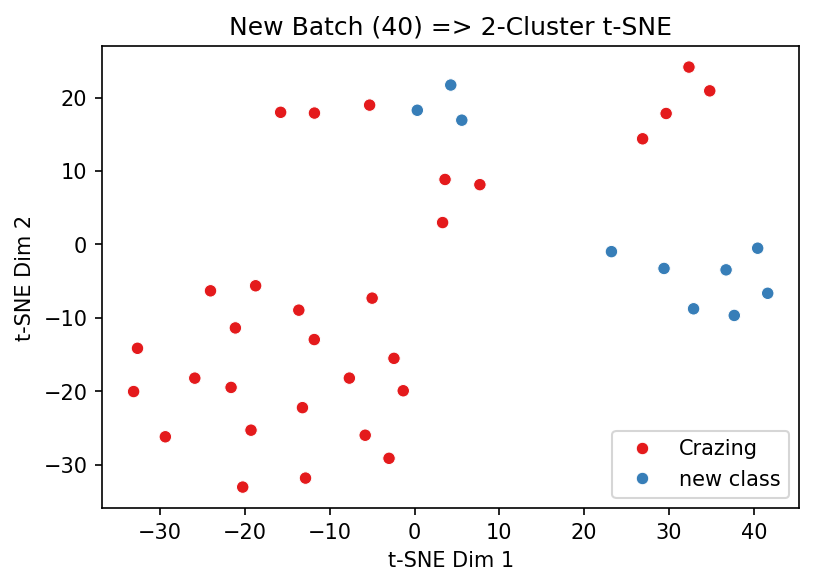

In [5]:
# Suppose you already have a PCA object (self.pca) and a batch of raw fc1 features (new_feats_4096).
# 1) Transform from 4096 -> 50
new_feats_50 = pca.transform(new_feats_4096)  # shape => (40, 50)

# 2) Now you can call KMeans
kmeans_2 = KMeans(n_clusters=2, random_state=42).fit(new_feats_50)
labels_2 = kmeans_2.labels_  # shape => (40,)

# 3) Plot or analyze
plot_newbatch_tsne(new_feats_50, labels_2)





In [6]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def plot_newbatch_inset_images(new_data_50, cluster_labels_2, image_paths):
    """
    new_data_50: shape (40,50)
    cluster_labels_2: shape (40,) -> 0/1
    image_paths: list of the 40 image paths in the same order as new_data_50
    We'll embed each point in t-SNE, then add a small image at some points.
    
    This example shows how to do insets for, say, 2 sample images from cluster #0
    and 2 from cluster #1. 
    """

    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=0, perplexity=10)
    x_2d = tsne.fit_transform(new_data_50)

    df = pd.DataFrame({
        'x_tsne': x_2d[:,0],
        'y_tsne': x_2d[:,1],
        'cluster_id': cluster_labels_2
    })

    # Plot the scatter
    fig, ax = plt.subplots(figsize=(6,4), dpi=150)
    sns.scatterplot(data=df, x='x_tsne', y='y_tsne',
                    hue='cluster_id', palette='Set2', ax=ax)
    plt.title("New Batch t-SNE with some images as insets")
    plt.xlabel("t-SNE-1")
    plt.ylabel("t-SNE-2")

    # For demonstration, let's pick 2 samples from cluster 0 and 2 from cluster 1
    # to show as inset images
    for c in [0, 1]:
        # get indices of that cluster
        idxs = np.where(cluster_labels_2 == c)[0]
        # pick 2 random indices from that cluster
        if len(idxs) < 2:
            sample_idxs = idxs
        else:
            sample_idxs = np.random.choice(idxs, size=2, replace=False)

        for i_ in sample_idxs:
            # read the image at image_paths[i_]
            # load in grayscale or color as needed
            pil_img = image.load_img(image_paths[i_], target_size=(64,64))
            arr_img = image.img_to_array(pil_img)/255.0  # 0..1
            # create an OffsetImage
            imagebox = OffsetImage(arr_img, zoom=1.0)
            ab = AnnotationBbox(imagebox, (df.loc[i_,'x_tsne'], df.loc[i_,'y_tsne']),
                                xycoords='data', frameon=False)
            ax.add_artist(ab)

    plt.legend(loc='best')
    plt.show()


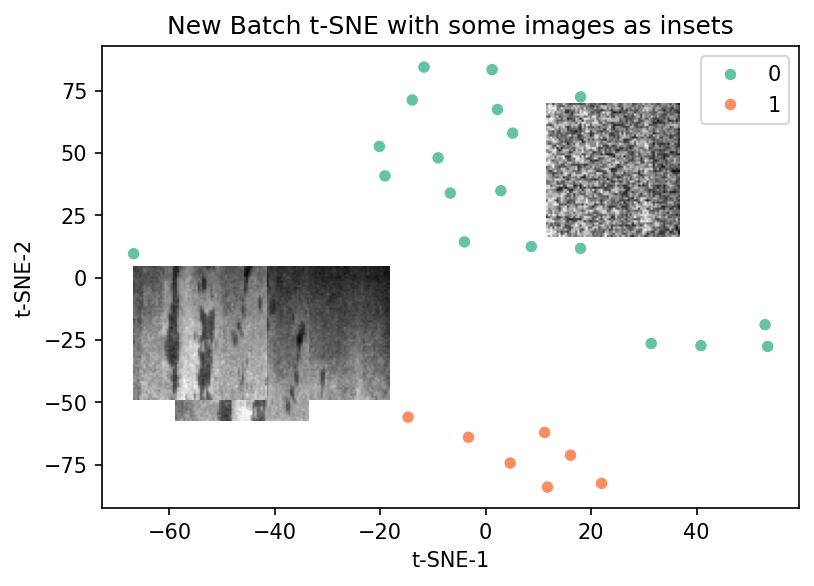

In [7]:
kmeans_2 = KMeans(n_clusters=2, random_state=42).fit(new_feats_50)
labels_2 = kmeans_2.labels_  # shape(40,)

image_paths = sorted(batch_dir.glob("*.bmp"))  # same order as new_feats_50
plot_newbatch_inset_images(new_feats_50, labels_2, image_paths)

